In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sys
import pickle

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
from tensorflow.keras.models import Model

In [ ]:
!pip install scikit-learn

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [5]:
def onehot_encoded_seq(seq):

    # remove any trailing new line characters
    seq = seq.rstrip()
    seq_array = np.array(list(seq))


    label_encoder = LabelEncoder()
    integer_encoded_seq = label_encoder.fit_transform(seq_array)
    integer_encoded_seq = integer_encoded_seq.reshape(len(integer_encoded_seq), 1)

    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    onehot_seq = onehot_encoder.fit_transform(integer_encoded_seq) #.tolist()
    onehot_seq = np.transpose(onehot_seq)


    # Fill in rows in onehot encoded array with nts not present in the sequence
    nt_onehot_index = {'A': 0, 'T': 3, 'G': 2, 'C': 1}

    all_nts = set(nt_onehot_index.keys())
    present_nts = set(seq)
    absent_nts = list(all_nts - present_nts)

    #print('absent_nts:', absent_nts, 'present_nts:', present_nts)

    for nt, _ in sorted(nt_onehot_index.items(), key=lambda x: x[1]):
        if nt in absent_nts:
            #print('nt:', nt, 'nt_onehot_index[nt]:', nt_onehot_index[nt])
            onehot_seq = np.insert(onehot_seq, nt_onehot_index[nt], [0], axis=0)


    return onehot_seq

In [6]:
def convert_onehot_to_raw_seq(onehot_seq):
    #print(onehot_seq)
    onehot_index_to_nt = {0: 'A', 3: 'T', 2: 'G', 1: 'C'}
    raw_seq = ''

    cnt = 0
    for cur_nt in onehot_seq:
            #print(cur_nt)

            t = np.where(cur_nt == 1)[0][0]
            #print(t)
            #print(onehot_index_to_nt[t])
            raw_seq += onehot_index_to_nt[t]

    return raw_seq

In [7]:
model = tf.keras.models.load_model('JARVIS-sequences.model')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq_input (InputLayer)       [(None, 3000, 4)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1495, 64)          2880      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 746, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 746, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 372, 64)           12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 185, 64)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 185, 64)           0     

In [9]:
patho_seq_chunks = pd.read_csv('/projects/cgr/users/kclc950/JARVIS/misc/deepbind/jarvis-input/Training_set.pathogenic_variant_sequences.txt', header=None)[0].values
patho_seq_chunks[:2]

array(['AATGGGAAATAATTTGAATCAGGATGGAACAATTGATAAGAAGAAAGAACAAACCAGCTAACCAAATAAACAGAAAGGTGTTCTTTCCTTGAAACTCTAGAACATAGGCAGGAGCCAGCCACATGGCCTGCCCTATAAACCATAACATTAGGAGAACTACAGCTCTTTTCCAAGGCATTCTGACTAGTGGCATCACAAGAGGCAGTAAGCAGAGGTACCAAAGAAAGTACTGGGAGGTGCAGACTTTGTTAAAAGTCACAAAAATGGACGTATGAAGAAAACAACAAAAAACGAGGTCTCTGTAATAGGCGAAAGACACAGCTGAAAGCAAGATGAGCTGTGGCAGGAATGCAGCAATTCCCAGGGAAAAACTCCACTTGCTCTCTGCAGTCAAATACAGCATGTAGAAGTACGGAGAAAAGTTGTGACGGATATCCCGCCTAGTCAGGTGATAAAAGTAGGTGTGTTCCAAAAATTCCCAGCCGTACTCATAGTAAAAA',
       'CCAAAGCTCAGGGCAAAAAACGTGAGTCCAGCAACTGCTACAAACAGCAGCACAGCCCGATTACACAGCCTTTTCAGGAGCTCGTACAAACAAGCCTGGAAAGTGTACCGGAATTGACGGAGGCTTTTGTCATTGTCGCGATCTGGAAGCAGGTGGAGGGTTATGGGAAGGATGTAAGTCACTGGATATATCTTCATATGCACCGCGAAACCATAGAATACAGCTGCACACGCGACGAGTCTTTTCTTTATCAAGTAGAGGACCATCAGGACCAGGGAGGCGACAATAGAGTCCGCATTACCGCGGCTGGATACTGCCATAGGCAGGGGGTTAAGAAGCCAAAAGACACAGTAGCCACAAGCCTGGCGGCGCCCCAGCCCCTTCAGCAGCAGCAGGCGGTATAAGAGGAAAGCGGTGAGGAGGTCGCAGCTGATGAAGAGAAACTTTCCAAAGAGCTCGCTGAGGTAGATGTTGGGAGTGA

In [10]:
benign_seq_chunks = pd.read_csv('/projects/cgr/users/kclc950/JARVIS/misc/deepbind/jarvis-input/Training_set.benign_variant_sequences.txt', header=None)[0].values
benign_seq_chunks[:2]

array(['AGGTATTTATTTTTTCAGAGATCAAAAATATTAATACTGTTGAGCTAGGGCCTACCCACCCGCCTGCATACACACATAATGTACTAAGTATAAAGAGGTAAGCTTCACTTCCCTAGTAGAATGGTGGTATAAAATAAAGGCCTCCCAACTCTTTCTTTCCTATTTGCATGGGGGATAAGGGTGGCAGAGGTTGTATACAACCATCTATGGCTTCTGGGAATTCGTACTATGTTGGGACACAGCAAAATATGTGGTCTTATACATAAGGTCTTGGTGATATTCTATGGAAAGTCAATGGGGACTTGAGGATAAATGAGTGTACTGCTAAAATGAGTGCACTGATAAAATTATCAGTTACCAGATTCATGACATGGAGATGTGAGGACAGGGGAAGGAGGTGGCAAAGAAATTTAGAAGGGACCTGATTGTTTGCCAGACTTAGAAGTTTGAATGCCCACAAATCACAAAGATGTCAGAGATCAGATTCAGTGAGAGTAAGG',
       'GAGTGGGGAAGTAGAAGGACAGGAGATGATGGTGTGAGAGGGACCTATAGAGAAAGGTTTTGGAAGTGAATGAATATTACATGGTAATAACGCAGCCATGCTAGTAAGCAGCTCAGGCATGGTGACTGCAGAGAACACTGGGACTGGGCAACTGAGAATCCAGTGGAATAAAAGGAATGTAAAAATTATGAAGCTATTTTTTTGAGCAAAATTTATGACTAACAGTAATTACAGTTACTACATGTTGGGAAGCAGATTAAAAGTGGAAAAATTTACACTAACAACAGGTAGAGTTTAGGTTGAATAATTCTTACCTCAATCATACTTAGCTTCCATGACAAATGCTCCTAGTTGCCTACTTGATATTTGTTTCCTCATCCTTCTTTTCTAAGAGAACTGTGATTTGTGTGCAAATGTGTGACAGTATTCCGGTGTTCCCAGTTGTATGTACTCGCAGTGAGGCCTCTCCTAAGAGTTAAGG

## Get 3kb input sequences from 500bp chunks

In [11]:
def concat_seq_chunks(seq_list, step=6):
    
    concat_seqs = []
    
    for chunk_idx in range(0, len(seq_list), step):
        cur_seq = ''.join(seq_list[chunk_idx: chunk_idx+step])
        
        #print(len(cur_seq))
        concat_seqs.append(cur_seq)
        
    return concat_seqs

In [12]:
patho_seqs = np.unique(concat_seq_chunks(patho_seq_chunks))
benign_seqs = np.unique(concat_seq_chunks(benign_seq_chunks))

In [13]:
print(len(patho_seqs))
len(benign_seqs)

369


521

In [14]:
onehot_encoded_seq(patho_seqs[0])
print(onehot_encoded_seq(patho_seqs[0]).shape)
print(onehot_encoded_seq(patho_seqs[0]).T.shape)

l = onehot_encoded_seq(patho_seqs[0]).T


np.array([onehot_encoded_seq(patho_seqs[0]).T]).shape

(4, 3000)
(3000, 4)


(1, 3000, 4)

In [15]:
custom_model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [16]:
feature_maps = custom_model.predict(np.array([onehot_encoded_seq(patho_seqs[0]).T]))

In [17]:
feature_maps.shape

(1, 1495, 64)

## Visualise filters

In [18]:
import matplotlib
import matplotlib.pyplot as plt

In [19]:
filters, biases = model.layers[1].get_weights()


# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [20]:
filters.shape

(11, 4, 64)

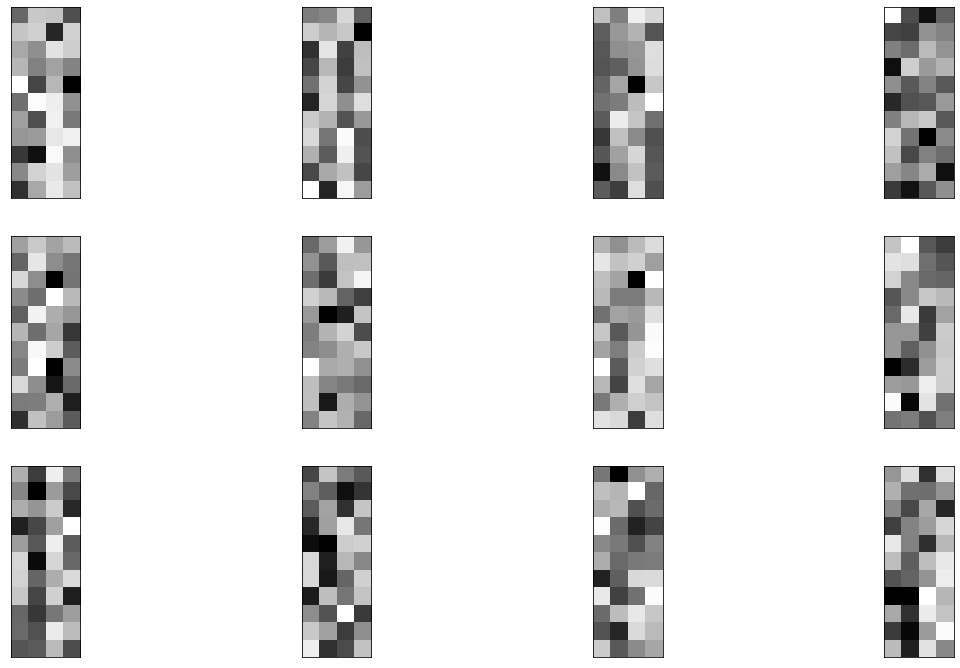

In [21]:
# plot first few filters
n_filters, ix = 12, 1

plt.figure(figsize=(20, 50))

for i in range(n_filters):
    # get the filter
    f = filters[:, :, i]
    
 
    # specify subplot and turn of axis
    ax = plt.subplot(n_filters, 4, ix)
    ax.set_xticks([])
    ax.set_yticks([])

    # plot filter channel in grayscale
    plt.imshow(f, cmap='gray')
    ix += 1

# show the figure
plt.show()


In [22]:
example_filter = filters[:, :, 3]
print(example_filter.shape)
example_filter

(11, 4)


array([[0.95699525, 0.39667684, 0.20937668, 0.46394157],
       [0.37489513, 0.35597792, 0.61472255, 0.5695325 ],
       [0.558927  , 0.4971008 , 0.7398158 , 0.61877453],
       [0.2065405 , 0.8034641 , 0.63887745, 0.717717  ],
       [0.6057696 , 0.43680868, 0.56748146, 0.44035324],
       [0.2871947 , 0.41281784, 0.4314809 , 0.6365124 ],
       [0.5602295 , 0.729451  , 0.7826263 , 0.43877706],
       [0.81568605, 0.51860416, 0.15800078, 0.59017366],
       [0.7614574 , 0.38435197, 0.5608677 , 0.4977076 ],
       [0.65732825, 0.57695603, 0.69234633, 0.20738137],
       [0.340773  , 0.2158725 , 0.4355731 , 0.6055618 ]], dtype=float32)

In [23]:
convert_onehot_to_raw_seq(np.round(filters[:, :, 3]))

'AGACATAAAAT'

## Get max. activation

In [24]:
L = 11 # filter length
offset = int(L/2)
strides = 2

In [26]:
filter_act_per_seq = {}

seq_cnt = 1
for seq in patho_seqs:
    #print(seq)
    if seq_cnt % 10 == 0:
        print(seq_cnt)
    seq_cnt += 1
    
    for i in range(offset, len(seq) - offset, strides):
        sub_seq = seq[i-offset: i+offset+1]
        
        #print(sub_seq)
        sub_onehot_seq = onehot_encoded_seq(sub_seq).T
        
        for f in range(filters.shape[2]):
            cur_filter = filters[:, :, f]
            
            sum_of_prod = np.sum(np.multiply(cur_filter, sub_onehot_seq))
            #print(sum_of_prod)
            
            filter_act_per_seq[sub_seq] = sum_of_prod

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360


In [30]:
with open('JARVIS-filter_act_per_seq.pkl', 'wb') as handle:
    pickle.dump(filter_act_per_seq, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
with open('JARVIS-filter_act_per_seq.pkl', 'rb') as handle:
    filter_act_per_seq = pickle.load(handle)

In [29]:
max_act = max(filter_act_per_seq.values())
top_percentile = 0.9 #0.9
patterns = []

pattern_cnt = 0
for seq, act in filter_act_per_seq.items():
    
    if act > top_percentile * max_act:
        #print(seq)
        #print(act)
        patterns.append(seq)
        pattern_cnt += 1
        
print(pattern_cnt)

2801


In [32]:
patterns[:10]

['AAAAAAGTCGG',
 'GGCCCCACCCC',
 'CCCCACCCCCA',
 'CCCCATCCGTC',
 'GCCCCTTCCCG',
 'TCCCGCGCTGA',
 'GCAGTCGCTGC',
 'AGTCGCTGCCT',
 'TCGCTGCCTGC',
 'TGCAACAAGGA']

## Write all pattern sequences into a FASTA file

In [30]:
seq_id = 1
with open('JARVIS-CNN_pattern_seqs.fasta', 'w') as out_fh:
    for seq in patterns:
        out_fh.write('>seq_' + str(seq_id) + '\n')
        out_fh.write(seq + '\n')
        
        seq_id += 1

## Write all pattern sequences into a sequences-only text file

In [31]:
with open('JARVIS-CNN_pattern_seqs.txt', 'w') as out_fh:
    for seq in patterns:
        out_fh.write(seq + '\n')

## TODO
- Cluster pattern sequences with _cd-hit_
- Within each cluster, produce WebLogo and get consensus sequence
- Run all final consensus patterns against DeepBind
- Calculate most prominent patterns (see "Quantification of motif importance" from DeepCpG paper)

## Run cd-hit from the _cdhit_ conda env

In [40]:
cd-hit-est -i JARVIS-CNN_pattern_seqs.fasta -o cdhit_seq_clusters.id80.W7.fa -c 0.8 -n 7